# Matrix Factorisation for Drug Target Interaction

This notebook will provide a run through of the group project undertaken at the University of Sheffield for the Data Analytics MSc. While this was a group project all code and comments are mine.

In [27]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tdc.multi_pred import DTI
import torch
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem

## Data Loading and Exploration

In [2]:
# load in the Kd dataset
# method also works with IC50 and Ki datasets
data = DTI(name = 'BindingDB_Kd')
data.convert_to_log(form = 'binding') # converted binding affinity values to log space for more stable training

Found local copy...
Loading...
Done!
To log space...


In [3]:
# split data using the tdc module random split using default 0.7, 0.1, 0.2 split
split = data.get_split(seed = 42, frac=[0.6, 0.05, 0.35])
train = split['train']
test = split['test']

In [14]:
# Combine training and test datasets
df = pd.concat([train, test], ignore_index=True, sort=False)

Now that the data is loaded in lets have a look at it

In [15]:
df.head()

,Drug_ID,Drug,Target_ID,Target,Y
0,4293.0,NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.031517
1,1611.0,NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.522879
2,3013848.0,CN[C@H]1CN(c2cccc(OC)c2)S(=O)(=O)c2sc(S(N)(=O)...,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.698970
3,4369101.0,CN[C@@H]1CN(c2cccc(OC)c2)S(=O)(=O)c2sc(S(N)(=O...,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,8.744727
4,1514.0,COc1cccc(N2C=Cc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.638272


The `Drug` column shows the SMILE representation of the drugs and the `Target` column is the protein sequence of the target. The final column `Y` is the binding affinity which has previously been converted to log space.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49660 entries, 0 to 49659
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Drug_ID    49660 non-null  float64
 1   Drug       49660 non-null  object 
 2   Target_ID  45536 non-null  object 
 3   Target     49660 non-null  object 
 4   Y          49660 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.9+ MB


While the dataset does include IDs for the Targets it has some NaN values that the Target column does not have, therefore this will not be used.

In [20]:
print('Unique drugs: ', len(pd.unique(df['Drug'])))
print('Unique targets: ', len(pd.unique(df['Target'])))

Unique drugs:  10313
Unique targets:  1397


## Data pre-processing

The matrix factorisation will require an index for each unique drug and target, this is done with the enumerate function in python.

In [21]:
# enumerate drugs and targets for easy indexing
ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug']))))
ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))

Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())

Now each unique drug and target has a number associated with it starting from zero that will be used to index for the matrix factorisation model. This dictionary will then be applied to both the training and test sets using a function to avoid duplicate code. The function also prepares the data set for PyTorch's Dataloader.

In [23]:
def data_loader(data, drug_dict, target_dict):
    # allows data to be correctly passed in to PyTorch DataLoader
    
    # apply ID dictionary to both drugs and targets
    data["Drug_DictID"] = data["Drug"].apply(lambda x:drug_dict.get(x))
    data["Target_DictID"] = data["Target"].apply(lambda x:target_dict.get(x))

    # convert data into expected data types
    drug_ID = data["Drug_DictID"].to_numpy()
    target_ID = data["Target_DictID"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label

In [24]:
x_train, y_train = data_loader(train, Drug_to_ID, Target_to_ID)
x_test, y_test = data_loader(test, Drug_to_ID, Target_to_ID)

The training and test data sets are now set up as ($N$, 2) arrays where $N$ is the number of entries in the dataset. The first column represents the drugs and the second column represents the targets.

In [25]:
x_train

array([[   0,    0],
       [   1,    0],
       [   2,    0],
       ...,
       [7536,   47],
       [7301, 1240],
       [7301, 1240]], dtype=int64)

The next step to prepare the data is to use the PyTorch `Dataloader` function so that it can be passed into the model.

In [28]:
class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_ = train
        self.label_ = label

    def __len__(self):
        # return size of dataset
        return len(self.feature_)

    def __getitem__(self, idx):
        return torch.tensor(self.feature_[idx], dtype=torch.long), torch.tensor(self.label_[idx], dtype=torch.float)

In [29]:
bs = 100 # batch size

train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

Now the data is prepared and ready to be implemented into the models.

## Base Matrix Factorisation Model

The first model to be tested has been called the base matrix factorisation model. This is the standard method for matrix factorisation where predictions are be obtained via $A*B^T=Y$ where $Y$ is a matrix of predictions for the binding affinity. This starts with defining a class for the model, this was obtained from a [Medium article](https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74).

### Creating the model

In [30]:
class MatrixFactorization(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)

        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items, 1)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)

    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        return pred.squeeze()

With the class for the model defined lets create it.

In [38]:
n_factors = 20 # number of latent factors

MF_model = MatrixFactorization(len(Drug_to_ID), len(Target_to_ID), n_factors)

### Model Training

The next step is to train the model, the following code was obtained from the same [Medium article](https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74) with some minor changes. This code allows for training with a GPU which helps to reduce training time.

In [39]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loss_func = torch.nn.MSELoss()

MF_model.to(dev)

train_losses = []
test_losses = []

num_epochs = 100

for epoch in range(0, num_epochs):
    count = 0
    cum_loss = 0.
    for i, (train_batch, label_batch) in enumerate(train_dataloader):
        count = 1 + i
        # Predict and calculate loss for user factor and bias
        optimizer = torch.optim.SGD([MF_model.user_biases.weight, MF_model.user_factors.weight,
                                     MF_model.item_biases.weight, MF_model.item_factors.weight],
                                    lr=0.05, weight_decay=1e-5)
        prediction = MF_model(train_batch[:, 0].to(dev), train_batch[:, 1].to(dev))
        loss = loss_func(prediction, label_batch.to(dev)).float()
        loss_item = loss.item()
        cum_loss += loss_item

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()

    train_loss = cum_loss / count
    train_losses.append(train_loss)

    cum_loss = 0.
    count = 0
    for i, (test_batch, label_batch) in enumerate(test_dataloader):
        count = 1 + i
        with torch.no_grad():
            prediction = MF_model(test_batch[:, 0].to(dev), test_batch[:, 1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            cum_loss += loss.item()

    test_loss = cum_loss / count
    test_losses.append(test_loss)
    if epoch % 5 == 0:
        print('epoch: ', epoch, ' avg training loss: ', train_loss, ' avg test loss: ', test_loss)

epoch:  0  avg training loss:  29.588659322945176  avg test loss:  24.071438669506968
epoch:  5  avg training loss:  10.165614018774336  avg test loss:  9.509340228930197
epoch:  10  avg training loss:  7.469274681844529  avg test loss:  7.122318899696642
epoch:  15  avg training loss:  6.206656903977606  avg test loss:  5.970702669008182
epoch:  20  avg training loss:  5.373304351879533  avg test loss:  5.216243654000954
epoch:  25  avg training loss:  4.750994533490223  avg test loss:  4.653450838203638
epoch:  30  avg training loss:  4.231967058910686  avg test loss:  4.192418937474652
epoch:  35  avg training loss:  3.7947211819849196  avg test loss:  3.805124494547401
epoch:  40  avg training loss:  3.434810575406263  avg test loss:  3.4846926465060544
epoch:  45  avg training loss:  3.1340227191615257  avg test loss:  3.2210583517460223
epoch:  50  avg training loss:  2.8848246335983276  avg test loss:  3.004171428784647
epoch:  55  avg training loss:  2.6758408151614437  avg tes

With the model trained lets look at the training and test losses.

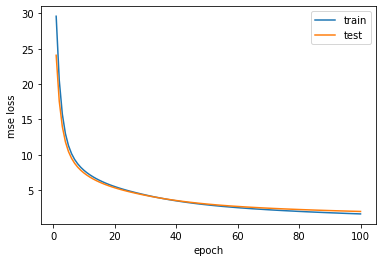

In [40]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
#     plt.savefig(img_name)
plt.show()

Both training and test losses decrease in a standard way, given the plateau training for more than 100 epochs is unlikely to yield a much better model.

 ### Model Evaluation

First step is to get the predictions for the test set for the final model

In [42]:
predictions = []
for i, (test_batch, label_batch) in enumerate(test_dataloader):
    count = 1 + i
    with torch.no_grad():
        prediction = MF_model(test_batch[:, 0].to(dev), test_batch[:, 1].to(dev))
        predictions.extend(list(prediction.cpu().numpy()))

For the metrics the MSE and the MAE will be used

In [43]:
from tdc import Evaluator
mse_evaluator = Evaluator(name = 'MSE')
mae_evaluator = Evaluator(name = 'MAE')

mse_score = mse_evaluator(y_test, predictions)
mae_score = mae_evaluator(y_test, predictions)

print('MSE: ', mse_score)
print('MAE: ', mae_score)

MSE:  1.9938160740089563
MAE:  0.8772664698006147


### Conclusion

This same problem has been attempted by a fellow University of Sheffield student and their solution can be found [here](https://github.com/pykale/pykale/tree/main/examples/bindingdb_deepdta). Their method is called DeepDTA and uses convolutional nueral networks to represent the drugs and the targets before concatenating them to achieve the final prediction. While only the MSE is calculated for their model it still provides some comparison. A table comparing the results can be seen below.


| Model                | MSE  |
|----------------------|------|
| Matrix Factorisation | 1.99 |
| DeepDTA              | 0.74 |

While the model proposed here does not perform as well it is still impressive given the relative simplicitiy of it. Therefore in an attempt to improve the model a new method is proposed to leverage the similarities between drugs and targets.